<a href="https://colab.research.google.com/github/viswanathgs/LLM-Training-Puzzles/blob/main/puzzles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Training Puzzles

by Sasha Rush ([@srush_nlp](https://twitter.com/srush_nlp))

In [1]:
%%capture
# Uncomment to run in Colab
!pip install -qqq git+https://github.com/chalk-diagrams/chalk asyncio
!wget https://raw.githubusercontent.com/srush/LLM-Training-Puzzles/main/lib.py https://raw.githubusercontent.com/srush/LLM-Training-Puzzles/main/drawing.py

In [2]:
from typing import List
from lib import Model, Dist, WeightGrad
from drawing import draw, draw_group
from chalk import vcat
import asyncio
import chalk
chalk.set_svg_height(400)
chalk.set_svg_draw_height(600)

## Preliminaries

The goal of these puzzles is to learn about distributed training of LLMs. However, we will be primarily concerned with a speed and memory efficiency of completing a single update of the models. To make things simpler, we will abstract away from the standard tensor-based transformer model, and just consider a state-less representation of each of the components of a multi-layer neural network.



In [3]:
model = Model(layers=2, batches=4)
weights, opt_states, activations, grad_activations, grad_weights = model.storage()

Our library has 5 parts:

* Weights
* Optimizer States - Values needed to update the weights
* Activations - The internal values computed on the forward pass
* Grad Activations - The gradients of the loss wrt to activations, needed for backward pass
* Grad Weights - The gradients of the loss wrt to weights, needed for updates

For these puzzles, you are *not allowed* to have local variables. You need to store each of these in the dictionary corresponding to its type.                      

We begin by tracing the lifecycle of a single model update.

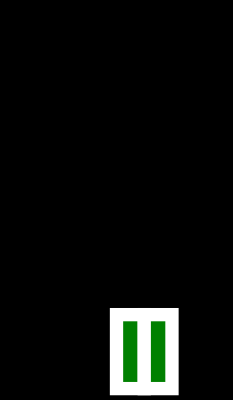

In [4]:
# Get the input activations to the model for batches 2, 3
activations[0] = model.get_activation(batches=[2, 3])
activations[0]

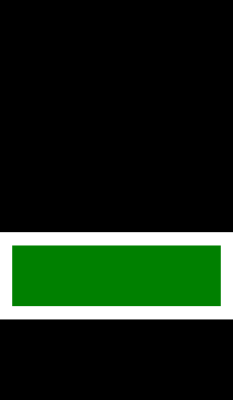

In [5]:
# Load the weights (random) for layers 0 and 1
for i in range(model.LAYERS):
    weights[i], opt_states[i] = model.load_weights(i)
weights[0]

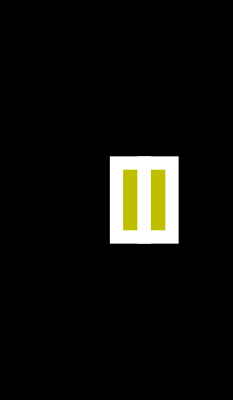

In [6]:
# Activations can be moved forward a layer if you have the weights.
activations[1] = model.forward(layer=0, inp=activations[0], weight=weights[0])
activations[2] = model.forward(layer=1, inp=activations[1], weight=weights[1])
activations[1]

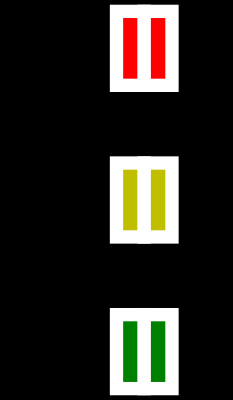

In [7]:
# Draw all the current activations in memory.
draw_group(activations)

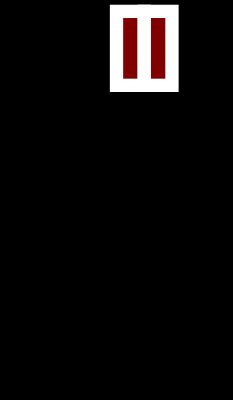

In [8]:
# At the last layer, we can convert an activation to a grad activation by calling `loss`
grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
grad_activations[model.LAYERS]

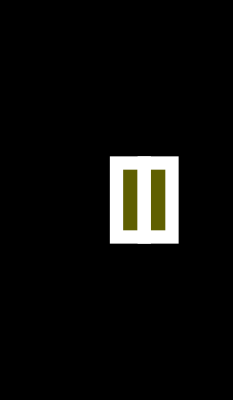

In [9]:
# Calling `backward` requires the forward activation, the backward grad activation, and the weights.
# It returns the grad weights and the backward activation.
grad_weights[1], grad_activations[1] = model.backward(1, activations[1], grad_activations[2], weights[1])
grad_weights[0], grad_activations[0] = model.backward(0, activations[0], grad_activations[1], weights[0])
grad_activations[1]

Before memory: 3145728.0
After memory: 2883584.0
0 <class 'lib.Weight'>,1 <class 'lib.Weight'>,0 <class 'lib.OptState'>,1 <class 'lib.OptState'>,0 <class 'lib.Activation'>,1 <class 'lib.Activation'>,2 <class 'lib.Activation'>,2 <class 'lib.ActivationGrad'>,0 <class 'lib.ActivationGrad'>,1 <class 'lib.WeightGrad'>,0 <class 'lib.WeightGrad'>,


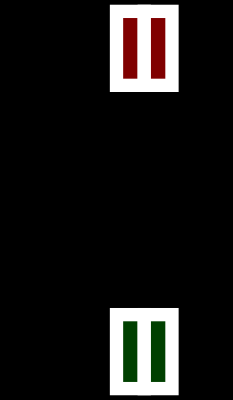

In [10]:
# We can use delete to remove any memory that is not longer needed.
print("Before memory:", model.memory())
del grad_activations[1]
print("After memory:", model.memory())
model.status()
draw_group(grad_activations)

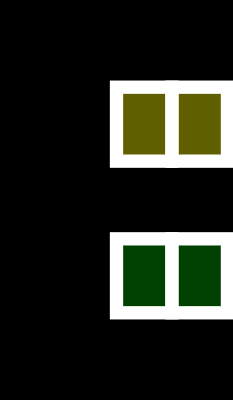

In [11]:
# Grad weights keep track of which batches they are for. Here we only have the grad weights for batches 2 and 3.
draw_group(grad_weights)

In [12]:
# If we try to update with the grad weights we will get an error.
try:
    model.update(0, weight_grad=grad_weights[0], weight=weights[0], opt_state=opt_states[0])
except AssertionError as e:
    print("Error! Only have batches")
    print(e)

Error! Only have batches
{2, 3}


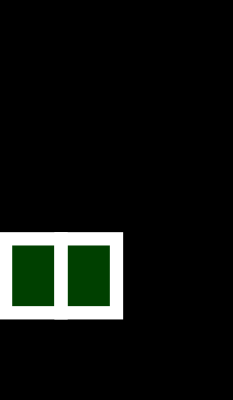

In [13]:
# For this example, we can cheat. Pretend we had the other gradients we needed.
grad_weights[0, 0] = model.fake_grad(0, [0,1])
grad_weights[1, 0] = model.fake_grad(1, [0,1])
grad_weights[0, 0]

In [14]:
# Summing together grad_weights gives the full gradient.
grad_weights[0] = grad_weights[0] + grad_weights[0, 0]

In [15]:
# Now we can call update to the get the new weights and opt_state.
weights[0], opt_states[0] = model.update(0, weight_grad=grad_weights[0], weight=weights[0],
                                         opt_state=opt_states[0])

# WARNING: You need to set all variables. Otherwise they are not counted towards memory.
grad_weights[1] = grad_weights[1] + grad_weights[1, 0]
weights[1], opt_states[1] = model.update(1, weight_grad=grad_weights[1],
                                         weight=weights[1], opt_state=opt_states[1])

Correct!


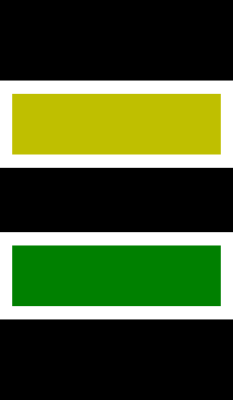

In [16]:
# We can complete the tests by setting these as the final weights and calling check.
model.set_final_weight(0, weights[0])
model.set_final_weight(1, weights[1])
Model.check([model])
draw_group(model.final_weights)

Timesteps: 8.5 
Maximum Memory: 3407872.0 at GPU: 0 time: 8


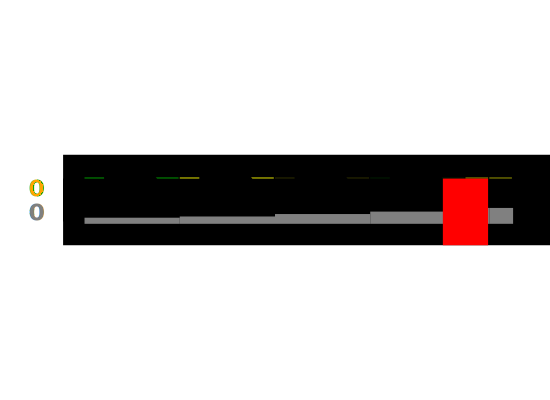

In [17]:
# We can view the final outcome of the system as a diagram.
# This show the forward and backward passes (numbers of batches) and the updates.
# The lines on the bottom show the memory that is used at each time step.
draw([model])

### Puzzle 0 - Standard Training

Write a standard (non-distributed) training loop that acts on all the batches and loads all the weights. It should just run forward, loss, backward, and update. Aim for the least amount of max memory used.

* Target Time:  17 steps
* Target Memory: 2600000

In [18]:
def basic(model: Model) -> Model:
    # Storage on device.
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()

    # Load the input layer activations
    activations[0] = model.get_activation(range(model.BATCHES))
    for l in range(model.LAYERS):
        weights[l], opt_states[l] = model.load_weights(l)
        activations[l + 1] = model.forward(l, activations[l], weights[l])
        del weights[l], opt_states[l]

    grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
    del activations[model.LAYERS]

    for l in range(model.LAYERS - 1, -1, -1):
        weights[l], opt_states[l] = model.load_weights(l)
        grad_weights[l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
        del activations[l], grad_activations[l + 1]

        weights[l], opt_states[l] = model.update(l, grad_weights[l], weights[l], opt_states[l])
        del grad_weights[l]

        model.set_final_weight(l, weights[l])
        del weights[l]
    del grad_activations[0]

    return model

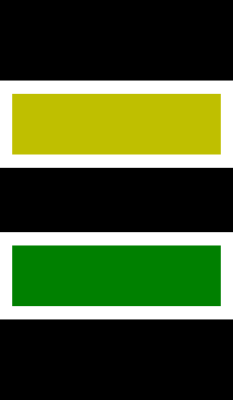

In [19]:
out = basic(Model(layers=2, batches=4, rank=0, dist=Dist(1)))
draw_group(out.final_weights)

Timesteps: 16.5 
Maximum Memory: 2097152.0 at GPU: 0 time: 8


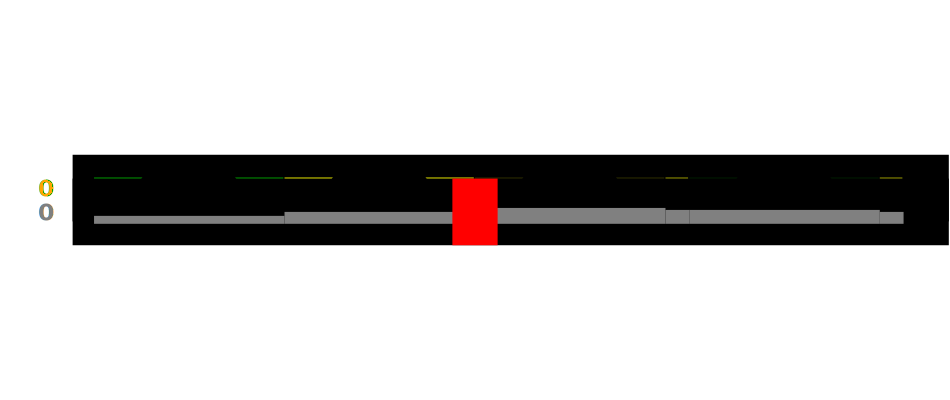

In [20]:
draw([out])

In [21]:
Model.check([out])

Correct!


### Puzzle 1 - Gradient Accumulation

For this puzzle, the goal is to reduce max memory usage. To do so you are going to run on each batch individually instead of all together.

Write a function with four parts. First run on batches {0} and then {1} etc. Sum the grad weights and then update.

* Target Time:  17 steps
* Target Memory: 2000000

In [22]:
def grad_accum(model: Model) -> Model:
    # Storage on device.
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()

    for b in range(model.BATCHES):
        activations[0] = model.get_activation([b])
        for l in range(model.LAYERS):
            weights[l], opt_states[l] = model.load_weights(l)
            activations[l + 1] = model.forward(l, activations[l], weights[l])
            del weights[l], opt_states[l]

        grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
        del activations[model.LAYERS]

        for l in range(model.LAYERS - 1, -1, -1):
            weights[l], opt_states[l] = model.load_weights(l)
            grad_weights[b, l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
            del activations[l], grad_activations[l + 1], weights[l], opt_states[l]

            grad_weights[l] = grad_weights[l] + grad_weights[b, l] if l in grad_weights else grad_weights[b, l]
            del grad_weights[b, l]
        del grad_activations[0]

    for l in range(model.LAYERS):
        weights[l], opt_states[l] = model.load_weights(l)
        weights[l], opt_states[l] = model.update(l, grad_weights[l], weights[l], opt_states[l])
        del grad_weights[l]
        model.set_final_weight(l, weights[l])
        del weights[l]

    return model

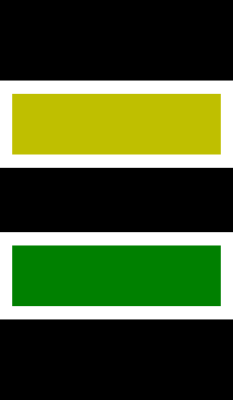

In [23]:
out = grad_accum(Model(layers=2, batches=4, rank=0, dist=Dist(1)))
draw_group(out.final_weights)

Timesteps: 16.5 
Maximum Memory: 1441792.0 at GPU: 0 time: 6


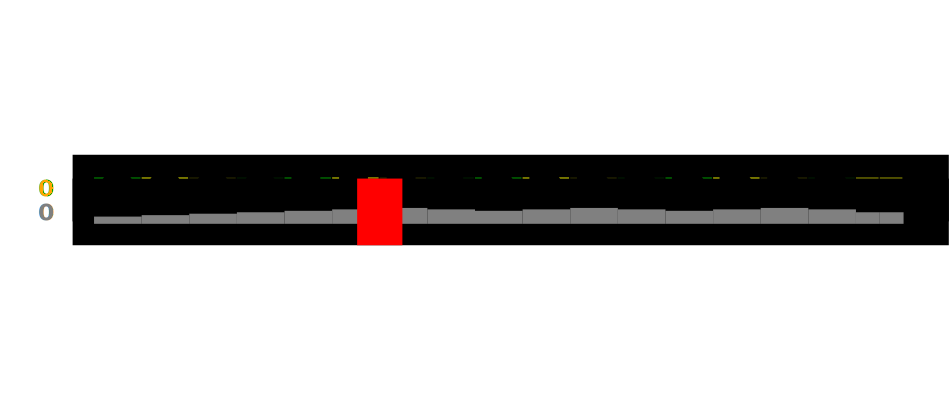

In [24]:
draw([out])

In [25]:
Model.check([out])

Correct!


## Communications: AllReduce

When working with multiple GPUs we need to have communication.
The primary communication primitives for GPUs are implemented in NCCL.

https://docs.nvidia.com/deeplearning/nccl/user-guide/docs/usage/operations.html

We are not going to use these directly, but simulate them using Python and asyncio.

The first operation is AllReduce. We will have 4 GPUs (ranks=4) and use them each to compute a batch of weight grads.

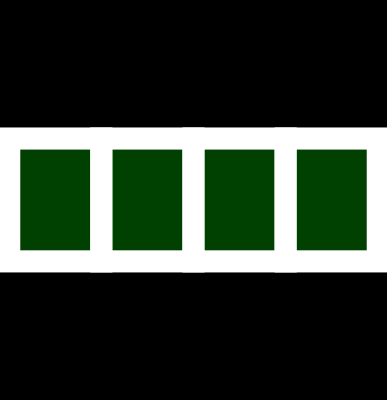

In [26]:
ranks = 4
weight_grads = [WeightGrad(0, 1, {i}, ranks) for i in range(ranks)]
weight_grads[0] + weight_grads[1] + weight_grads[2] + weight_grads[3]

In [27]:
# Simple asynchronous function that calls allreduce to sum the weight grads at layer 0
async def myfunc(model: Model) -> WeightGrad:
    return await model.allreduce(weight_grads[model.rank], 0)

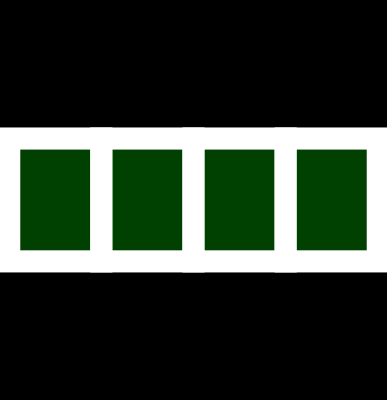

In [28]:
# This code uses asyncio to run the above function on 4 "GPUs" .
dist = Dist(ranks)
out_weight_grads = await asyncio.gather(*[
    myfunc(Model(layers=1, batches=1, rank=i, dist=dist))
    for i in range(ranks)])
out_weight_grads[0]

Note: When running communication operations like AllReduce on a GPU, the communication happens in parallel to the computation on that GPU. That means the API for AllReduce does not block, and allows the model to continue running while waiting for this command to run. This means it is beneficial to run AllReduce (and other communication) as early as possible so that other compute can be run during the reduction.

We will ignore this in these puzzles and represent communication as happening efficiently.

### Puzzle 2 - Distributed Data Parallel

Write a function with four parts. First run on batches {0} and then {1} etc. Sum the grad weights and then update. The main benefit of this approach is compute efficiency over gradient accumulation.

* Total Steps: 5
* Total Memory: 1800000

In [29]:
async def ddp(model: Model) -> Model:
    # Storage on device.
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()

    activations[0] = model.get_activation([model.rank])
    for l in range(model.LAYERS):
        weights[l], opt_states[l] = model.load_weights(l)
        activations[l + 1] = model.forward(l, activations[l], weights[l])
        del weights[l], opt_states[l]

    grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
    del activations[model.LAYERS]

    for l in range(model.LAYERS - 1, -1, -1):
        weights[l], opt_states[l] = model.load_weights(l)
        grad_weights[l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
        del activations[l], grad_activations[l + 1]

        grad_weights[l] = await model.allreduce(grad_weights[l], l)

        weights[l], opt_states[l] = model.update(l, grad_weights[l], weights[l], opt_states[l])
        del grad_weights[l]

        model.set_final_weight(l, weights[l])
        del weights[l]

    del grad_activations[0]

    return model

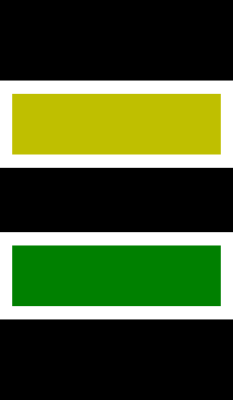

In [30]:
dist = Dist(ranks)
out = await asyncio.gather(*[
    ddp(Model(layers=2, batches=ranks, rank=i, dist=dist))
    for i in range(ranks)])
draw_group(out[0].final_weights)

Timesteps: 5.1 
Maximum Memory: 1179648.0 at GPU: 0 time: 4.8


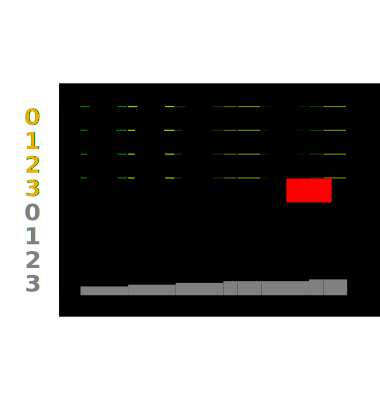

In [31]:
draw(out)

In [32]:
Model.check(out)

Correct!


## Communication: AllGather / Sharding

Our next primitive is AllGather. This allows us to communicate "shards" of an object stored on different GPUs to all the GPUs.

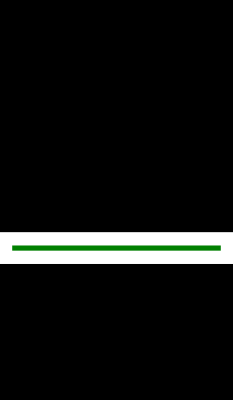

In [33]:
# Load only part of a weights.
model = Model(layers=2, batches=1, rank=0, dist=Dist(1))
weight, _ = model.load_weights(0, shard=0, total=4)
weight

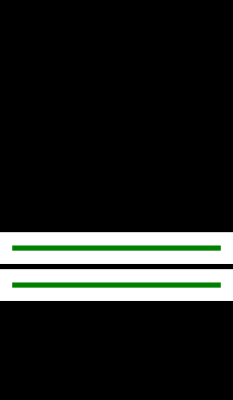

In [34]:
# Combine together two shards on one machine.
weights = [model.load_weights(0, shard=i, total=ranks)[0] for i in range(ranks)]
weights[0].combine(weights[2])

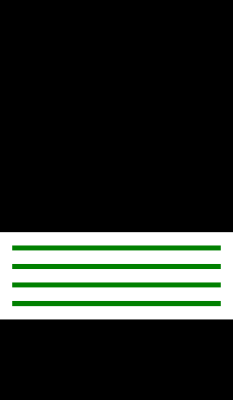

In [35]:
# Use allgather to collect the shards from all machines.
async def mygather(model: Model) -> WeightGrad:
    # Allreduce sums together all the weight grads
    return await model.allgather(weights[model.rank], 0)

dist = Dist(ranks)
out_weights = await asyncio.gather(*[
    mygather(Model(layers=1, batches=1, rank=i, dist=dist))
    for i in range(ranks)])
out_weights[0]

### Puzzle 3: Weight-Sharded Data Parallel

Run a model that shards each layer weight over all the machines. Reconstruct the layer weight at each layer using allgather. Finally update the weights on each machine using allreduce.

* Total Steps: 20
* Total Memory: 2800000

In [36]:
async def wsdp(model: Model) -> Model:
    # Storage on device.
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()

    activations[0] = model.get_activation([model.rank])
    for l in range(model.LAYERS):
        weights[l], opt_states[l] = model.load_weights(l, model.rank, model.RANKS)
        weights[l] = await model.allgather(weights[l], l)
        activations[l + 1] = model.forward(l, activations[l], weights[l])
        del weights[l], opt_states[l]

    grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
    del activations[model.LAYERS]

    for l in range(model.LAYERS - 1, -1, -1):
        weights[l], opt_states[l] = model.load_weights(l, model.rank, model.RANKS)
        weights[l] = await model.allgather(weights[l], l)
        grad_weights[l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
        del activations[l], grad_activations[l + 1]

        # print(f"DEBUG: before allreduce {l=} {model.rank=} {grad_weights[l].batches=} {grad_weights[l].shards=}")
        grad_weights[l] = await model.allreduce(grad_weights[l], l)
        # print(f"DEBUG: after allreduce {l=} {model.rank=} {grad_weights[l].batches=} {grad_weights[l].shards=}")

        weights[l], opt_states[l] = model.update(l, grad_weights[l], weights[l], opt_states[l])
        del grad_weights[l]

        model.set_final_weight(l, weights[l])
        del weights[l]

    del grad_activations[0]

    return model

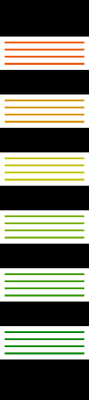

In [37]:
dist = Dist(ranks)
out = await asyncio.gather(*[
    wsdp(Model(layers=6, batches=ranks, rank=i, dist=dist))
    for i in range(ranks)])
draw_group(out[1].final_weights)

Timesteps: 19.900000000000006 
Maximum Memory: 1376256.0 at GPU: 0 time: 9.1


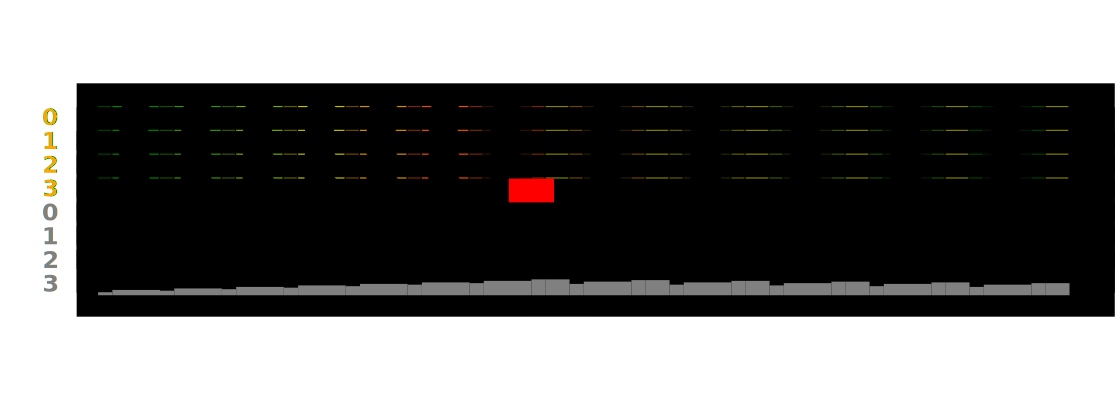

In [38]:
draw(out)

In [39]:
Model.check(out)

Correct!


## Communication: Scatter-Reduce

Scatter across shards
Reduce across batches

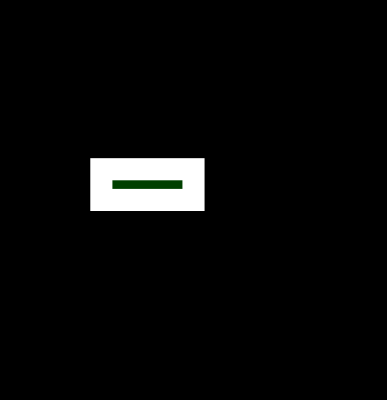

In [40]:
grad_weight = WeightGrad(0, 1, batches={1}, total_batches=4,
                         shards={1}, total=4)
grad_weight

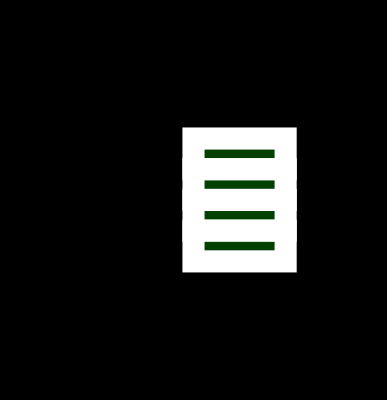

In [41]:
grad_weights = {i: WeightGrad(0, 1, batches={i}, total_batches=4,
                         shards={0,1,2,3}, total=4) for i in range(4)}
grad_weights[2]

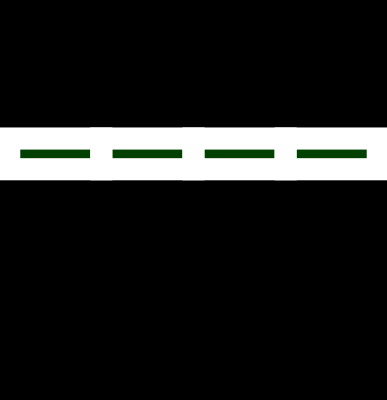

In [ ]:
async def scatterreduce(model: Model) -> WeightGrad:
    # Allreduce sums together all the weight grads
    return await model.scatterreduce(grad_weights[model.rank], 0)

dist = Dist(ranks)
out = await asyncio.gather(*[
    scatterreduce(Model(layers=1, batches=1, rank=i, dist=dist))
    for i in range(ranks)])
out[0]

### Puzzle 4: Fully-Sharded Data Parallel

Run a model that shards each layer weight over all the machines. Reconstruct the layer weight at each layer using allgather. Collect the gradients with scatter-reduce.

* Total Steps: 20
* Total Memory: 2300000

In [55]:
async def fsdp(model: Model) -> Model:
    # Storage on device.
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()

    activations[0] = model.get_activation([model.rank])
    for l in range(model.LAYERS):
        weights[l], opt_states[l] = model.load_weights(l, model.rank, model.RANKS)
        weights[l] = await model.allgather(weights[l], l)
        activations[l + 1] = model.forward(l, activations[l], weights[l])
        del weights[l], opt_states[l]

    grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
    del activations[model.LAYERS]

    for l in range(model.LAYERS - 1, -1, -1):
        weights[l, model.rank], opt_states[l] = model.load_weights(l, model.rank, model.RANKS)
        weights[l] = await model.allgather(weights[l, model.rank], l)

        grad_weights[l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
        del activations[l], grad_activations[l + 1], weights[l]

        # print(f"DEBUG: before scatterreduce {l=} {model.rank=} {grad_weights[l].batches=} {grad_weights[l].shards=}")
        grad_weights[l, model.rank] = await model.scatterreduce(grad_weights[l], l)
        del grad_weights[l]
        # print(f"DEBUG: after scatterreduce {l=} {model.rank=} {grad_weights[l, model.rank].batches=} {grad_weights[l, model.rank].shards=}")

        weights[l, model.rank], opt_states[l] = model.update(l, grad_weights[l, model.rank], weights[l, model.rank], opt_states[l])
        del grad_weights[l, model.rank]

        model.set_final_weight(l, weights[l, model.rank])
        del weights[l, model.rank]

    del grad_activations[0]

    return model

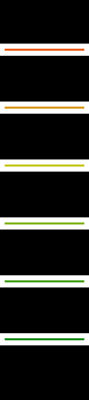

In [56]:
dist = Dist(ranks)
out = await asyncio.gather(*[
    fsdp(Model(layers=6, batches=ranks, rank=i, dist=dist))
    for i in range(ranks)])
draw_group(out[1].final_weights)

Timesteps: 19.900000000000006 
Maximum Memory: 1310720.0 at GPU: 0 time: 8.1


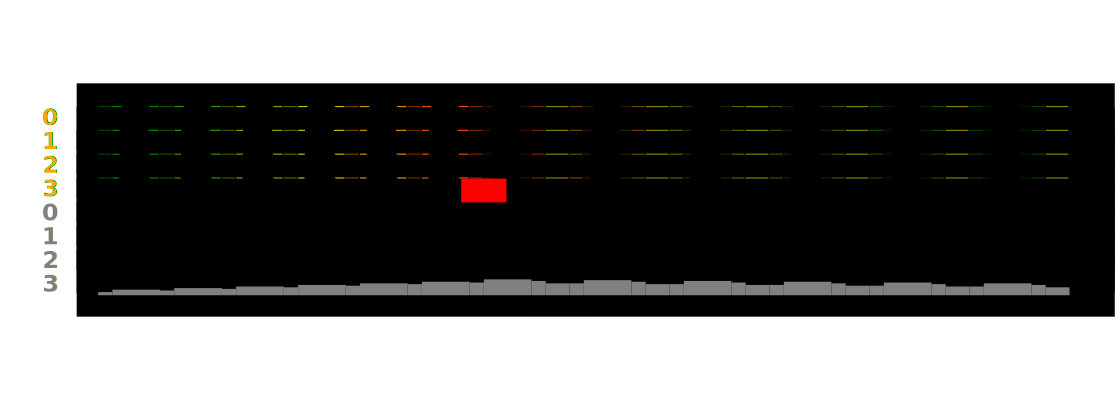

In [57]:
draw(out)

In [58]:
Model.check(out)

Correct!


## Communication: Point-to-Point

An alternative approach to communication is to directly communicate specific information between GPUs. In our model, both GPUs talking to each other block and wait for the handoff.

In [ ]:
async def talk(model: Model) -> None:
    if model.rank == 0:
        await model.pass_to(1, "extra cheese")
        val = await model.receive()
        print(val)
    else:
        val = await model.receive()
        print(val)
        val = await model.pass_to(0, "pizza")

dist = Dist(2)
result = await asyncio.gather(*[
    talk(Model(layers=1, batches=1, rank=i, dist=dist))
    for i in range(2)])

extra cheese
pizza


### Puzzle 5: Pipeline Parallelism

Split the layer weights and optimizers equally between GPUs. Have each GPU handle only its layer. Pass the full set of batches for activations and grad_activations between layers using p2p communication. No need for any global communication.

* Total Steps: 66
* Total Memory: 3300000

In [63]:
async def pipeline(model: Model) -> Model:
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()
    per_rank = model.LAYERS // model.RANKS
    my_layers = list([l + (model.rank * per_rank) for l in range(per_rank)])

    if model.rank == 0:
      assert my_layers[0] == 0
      activations[0] = model.get_activation(range(model.BATCHES))
    else:
      activations[my_layers[0]] = await model.receive()

    for l in my_layers:
        weights[l], opt_states[l] = model.load_weights(l)
        activations[l + 1] = model.forward(l, activations[l], weights[l])
        del weights[l], opt_states[l]

    if model.rank < model.RANKS - 1:
        await model.pass_to(model.rank + 1, activations[l + 1])
        grad_activations[l + 1] = await model.receive()
    else:
        assert l + 1 == model.LAYERS
        grad_activations[model.LAYERS] = model.loss(activations[model.LAYERS])
        del activations[model.LAYERS]

    for l in reversed(my_layers):
        weights[l], opt_states[l] = model.load_weights(l)
        grad_weights[l], grad_activations[l] = model.backward(l, activations[l], grad_activations[l + 1], weights[l])
        del activations[l], grad_activations[l + 1]

        weights[l], opt_states[l] = model.update(l, grad_weights[l], weights[l], opt_states[l])
        del grad_weights[l]

        model.set_final_weight(l, weights[l])
        del weights[l]

    if model.rank > 0:
        await model.pass_to(model.rank - 1, grad_activations[l])
    del grad_activations[l]

    return model

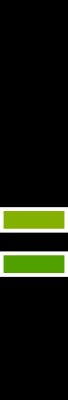

In [64]:
dist = Dist(ranks)
out = await asyncio.gather(*[
    pipeline(Model(layers=8, batches=ranks, rank=i, dist=dist))
    for i in range(ranks)])
draw_group(out[1].final_weights)

Timesteps: 69.9 
Maximum Memory: 2621440.0 at GPU: 0 time: 61.40000000000001


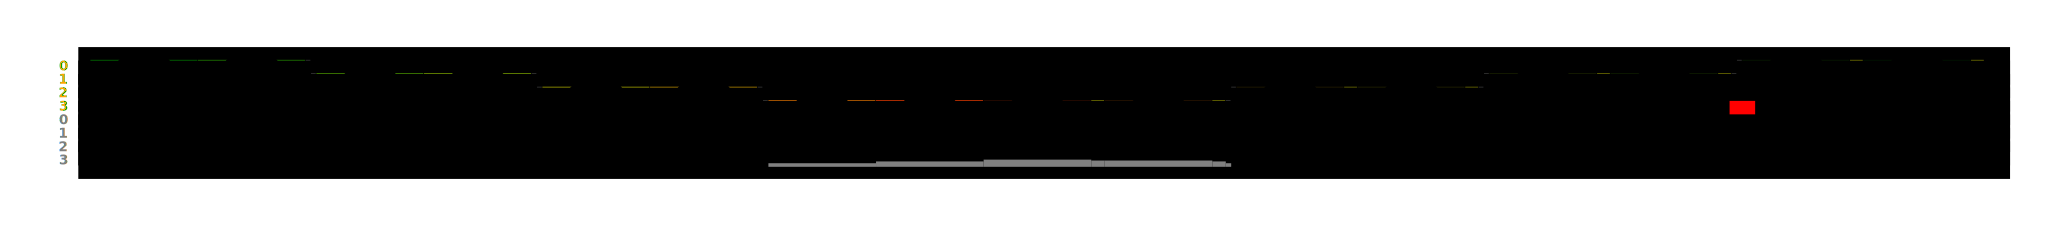

In [65]:
draw(out)

In [66]:
Model.check(out)

Correct!


### Puzzle 6: GPipe Schedule

A major issue with the pipeline approach is that it causes a "bubble", i.e. time in the later layers waiting for the earlier layers to complete. An alternative approach is to split the batches smaller so you can pass them earlier.

In this puzzle, you should run each batch by itself, and then pass. The graph should look similar as the one above but with a smaller bubble.

* Total Steps: 33
* Total Memory: 4100000

In [ ]:
async def gpipe(model: Model) -> Model:
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()
    per_rank = model.LAYERS // model.RANKS
    my_layers = list([l + (model.rank * per_rank) for l in range(per_rank)])
    for l in my_layers:
        weights[l], opt_states[l] = model.load_weights(l)

    assert False, 'TODO: Implement me'
    for l in my_layers:
        model.set_final_weight(l, weights[l])

    return model

In [ ]:
dist = Dist(ranks)
out = await asyncio.gather(*[
    gpipe(Model(layers=8, batches=ranks, rank=i, dist=dist))
    for i in range(ranks)])
draw_group(out[1].final_weights)

AssertionError: TODO: Implement me

Timesteps: 19.900000000000006 
Maximum Memory: 1310720.0 at GPU: 0 time: 8.1


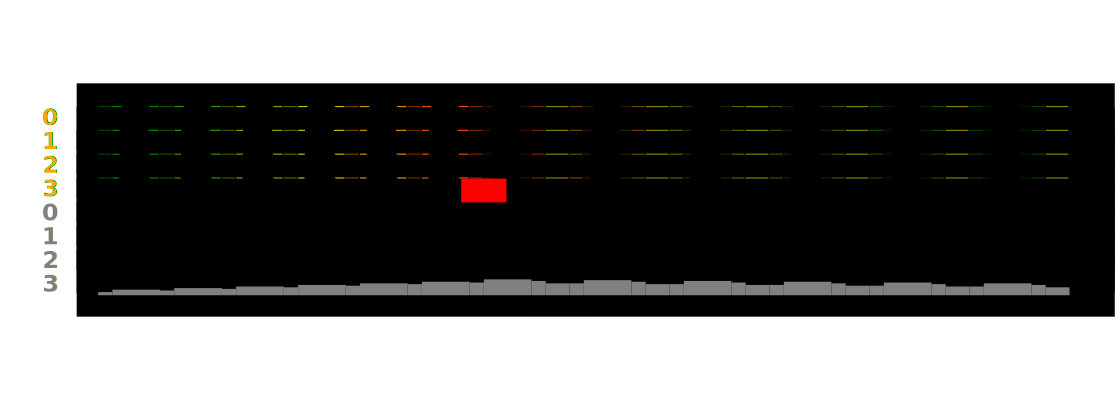

In [ ]:
draw(out)

In [ ]:
Model.check(out)

Correct!


### Puzzle 7: Pipeline + FSDP

As a last exercise, we can put everything together. Here we are going to run a combination of pipeline parallelism while also sharding our weight between 16 different machines. Here the model only has 4 layers, so we will assign 4 GPUs to each layer in the pipeline parallel approach.

This example requires combining both collective communication and p2p communication effectively.

* Total Steps: 15
* Total Memory: 1000000

In [ ]:
async def pipeline_fsdp(model: Model) -> Model:
    weights, opt_states, activations, grad_activations, grad_weights = model.storage()
    per_rank = model.LAYERS // (model.RANKS // 4)
    my_layers = list([l + ((model.rank % 4)  * per_rank) for l in range(per_rank)])
    for l in range(model.LAYERS):
        weights[l, 0], opt_states[l, 0] = model.load_weights(l, model.rank, model.RANKS)
    def empty_grad(l):
        return model.fake_grad(l, [])
    assert False, 'TODO: Implement me'
    for l in range(model.LAYERS):
        model.set_final_weight(l, weights[l])
    # Update
    return model

In [ ]:
dist = Dist(16)
out = await asyncio.gather(*[
    pipeline_fsdp(Model(layers=4, batches=ranks, rank=i, dist=dist))
    for i in range(16)])

AssertionError: TODO: Implement me

Correct!
Timesteps: 19.900000000000006 
Maximum Memory: 1310720.0 at GPU: 0 time: 8.1


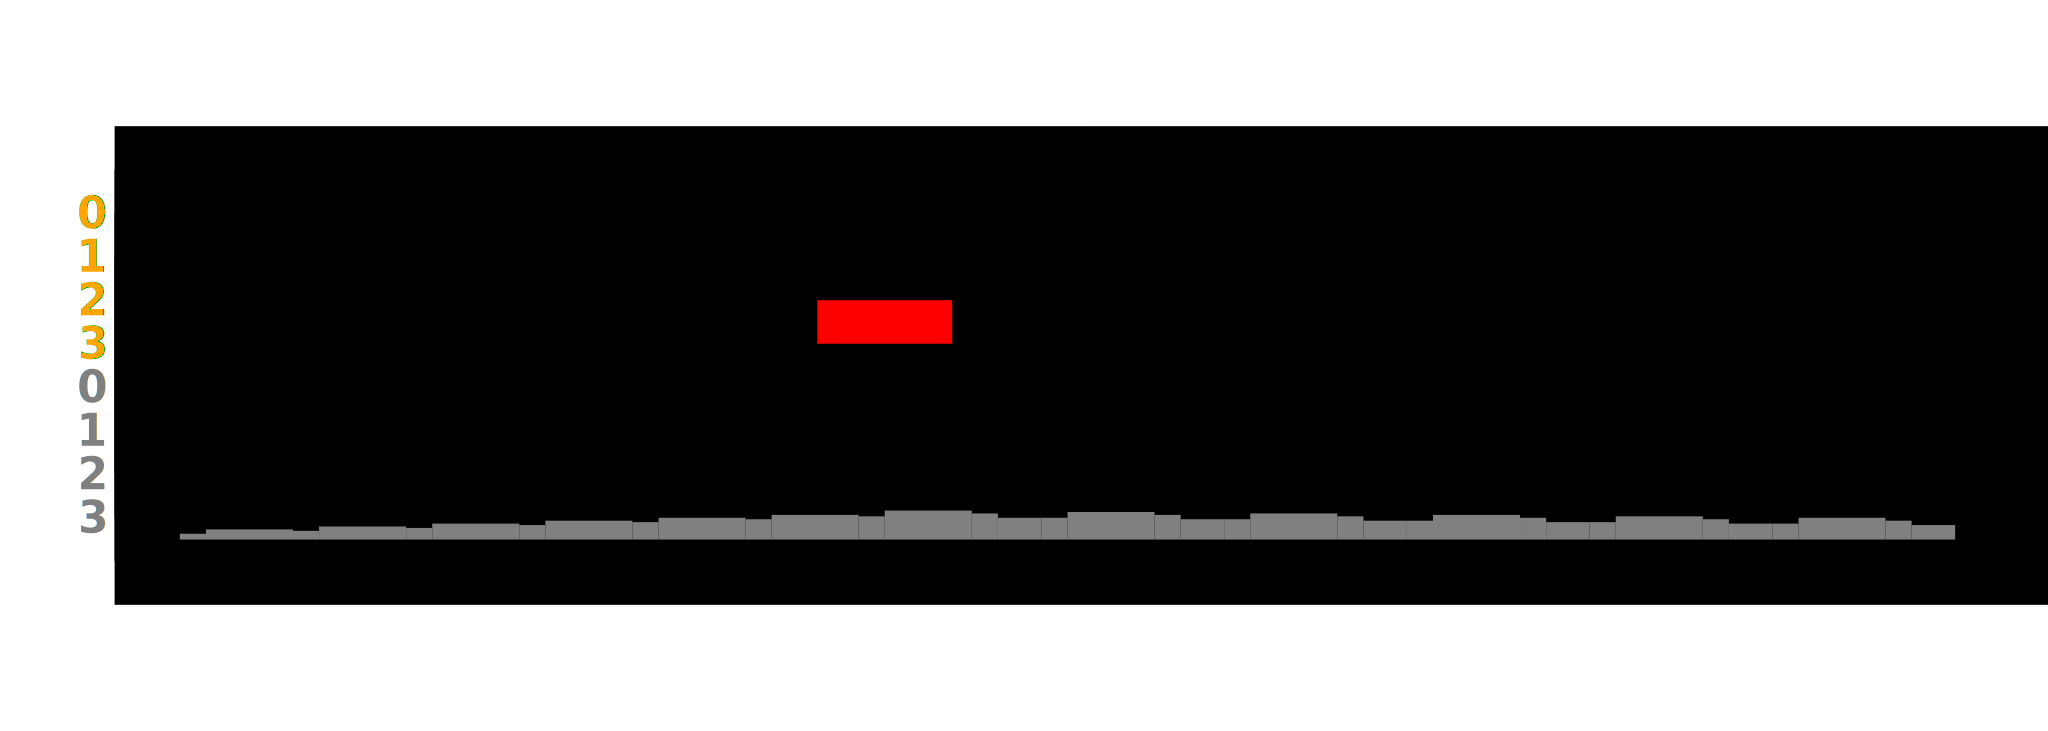

In [ ]:
Model.check(out)
chalk.set_svg_height(1000)
chalk.set_svg_draw_height(1000)

draw(out)

### When does it make sense to combine?

The goal of these exercises is to give you a sense of the different methods out there for distributed training. However, there is not currently a one size fits all approach for distributed training. The right choice will depend on the constants such as batch size, memory per GPU, communication overhead, implementation complexity, model size, and specifics of architecture.

As an example  of what's left to explore, this last method Pipeline + FSDP is often not a great choice due to the complexities of communication speed. And in fact GPipe + FSDP also gets you into a bad place. The paper [Breadth First Pipeline Parallelism](https://arxiv.org/pdf/2211.05953.pdf) proposes instead a combination of pipeline scheduling and communication. Here's what it looks like.

![image.png](https://github.com/srush/LLM-Training-Puzzles/assets/35882/f286089a-83bd-483c-b441-f154821d161c)